# loading the dataset #

In [1]:
import os
import sys
import time
import random
import pickle
import h5py
import numpy as np
import random


# TensorFlow / Keras
import tensorflow as tf
from keras import backend as K
from keras.models import Model, Sequential, load_model
from keras.layers import (
    Input, Dense, Flatten,
    Conv1D, SeparableConv1D,
    MaxPooling1D, AveragePooling1D,
    GlobalAveragePooling1D, GlobalMaxPooling1D,
    BatchNormalization, Activation, add
)
from keras.optimizers import Adam
from keras.callbacks import (
    ModelCheckpoint,
    Callback,
    LearningRateScheduler
)
from keras.utils import to_categorical

# Scikit-learn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt

# Progress bars
from tqdm.notebook import tqdm_notebook

# Silence TensorFlow logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


In [2]:
import h5py
import numpy as np
from tqdm import tqdm
from utiles import *
from MRE import *

from sklearn import preprocessing
HW = [bin(n).count("1") for n in range(0,256)]

AES_sbox=[
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76,
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0,
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15,
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75,
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84,
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf,
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8,
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2,
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73,
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb,
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79,
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08,
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a,
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e,
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf,
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16
]

def load_dataset(repo):
    ascad_database_file = repo
    f  = h5py.File(repo, "r")
    
    X_profiling = f['Profiling_traces/traces'][()]
    Y_profiling = f['Profiling_traces/labels'][()]
    meta_profiling = f['Profiling_traces/metadata'][()]
    p_key = meta_profiling['key']
    
    X_attack = f['Attack_traces/traces'][()]
    Y_attack = f['Attack_traces/labels'][()]
    meta_attack = f['Attack_traces/metadata'][()]
    
    # Attack traces all have the same key
    real_key = meta_attack['key']
    pt_attack = meta_attack['plaintext']
    

    
    return X_profiling, Y_profiling, X_attack, Y_attack , real_key,p_key

In [3]:
dataset_directory = r'C:\datasets\ASCAD.h5'  
X_profiling, Y_profiling, X_attack, Y_attack , real_key,p_key = load_dataset(dataset_directory)

# preparing the data #

In [4]:

# Choose the name of the model
nb_epochs = 50
batch_size = 50
input_size = 700
learning_rate = 5e-3
nb_traces_attacks = 400
nb_attacks = 100

(X_profiling, Y_profiling) = shuffle_data(X_profiling, Y_profiling)

X_profiling = X_profiling.astype('float32')
X_attack = X_attack.astype('float32')

#Standardization and Normalization (between 0 and 1)
scaler = preprocessing.StandardScaler()
X_profiling = scaler.fit_transform(X_profiling)
X_attack = scaler.transform(X_attack)

X_profiling , X_attack = horizontal_standardization(X_profiling , X_attack)
X_profiling = X_profiling.reshape((X_profiling.shape[0], X_profiling.shape[1], 1))



X_attack = X_attack.reshape((X_attack.shape[0], X_attack.shape[1], 1))


# load model #

In [5]:
model_directory = ''
model = load_model(r'C:\UNCERTANITY code\notebooks\models\wouters.hdf5')

# variational distribution #

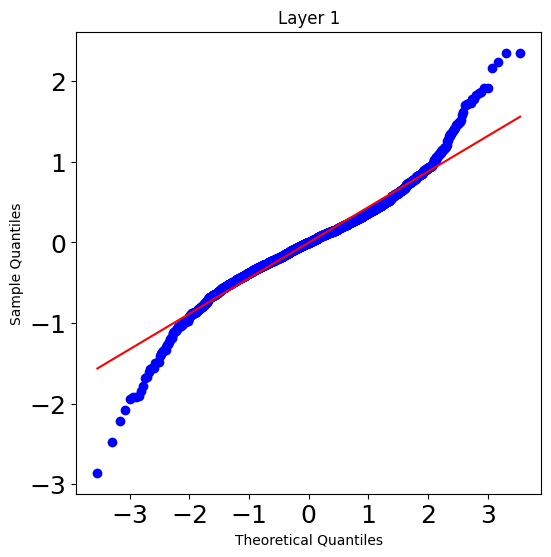

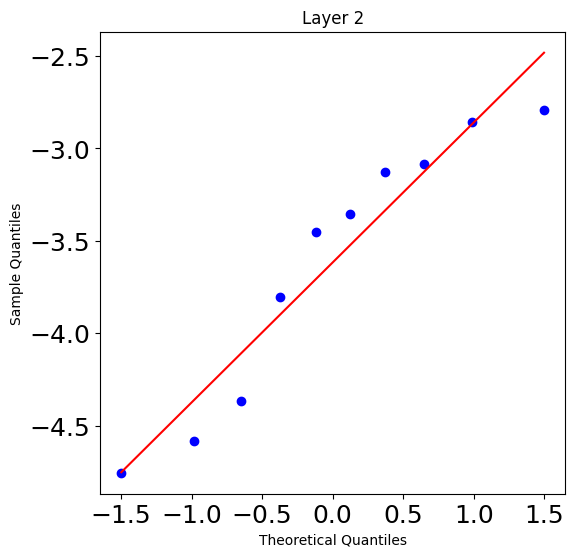

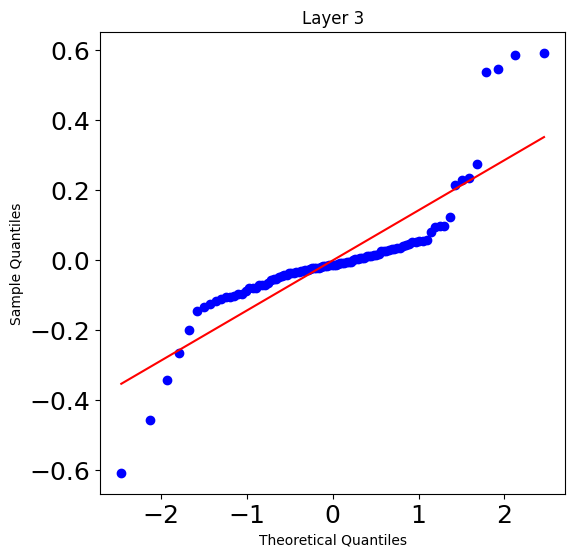

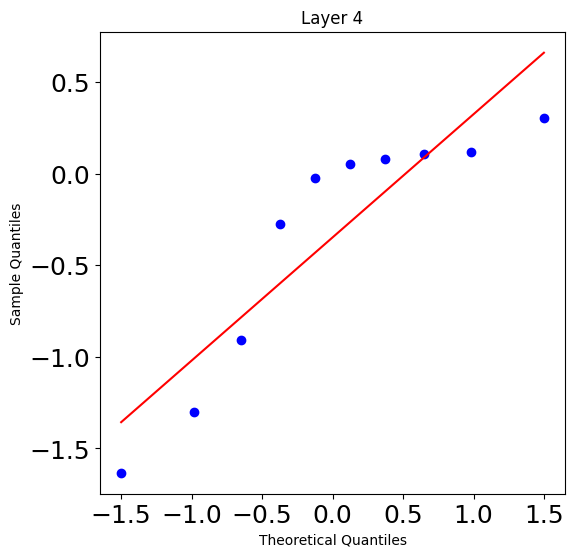

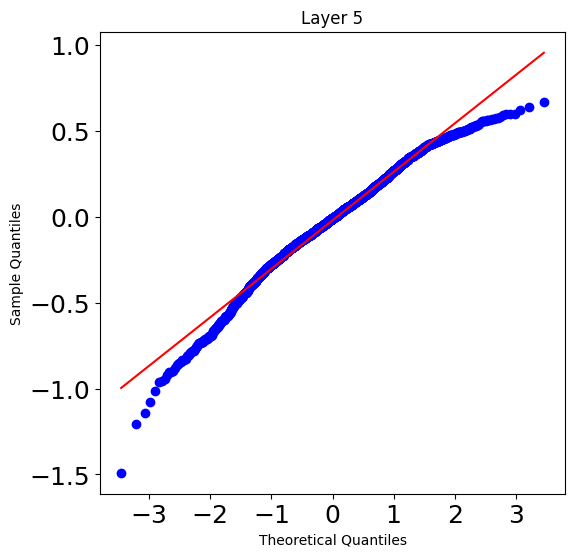

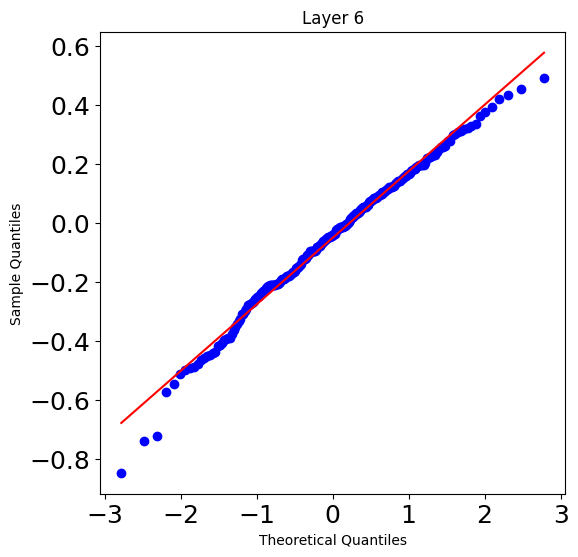

In [14]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as stats

# Extract weights from the model
weights = model.get_weights()

# Test normality using Q-Q plots and calculate mean and std
means, stds = [], []


for i, weight_matrix in enumerate(weights):
    # Flatten the weight matrix
    flat_weights = weight_matrix.flatten()
    
    # Q-Q plot
    plt.figure(figsize=(6, 6))
    stats.probplot(flat_weights, dist="norm", plot=plt)
    plt.title(f'Layer {i+1}')                      # Customize title font
    plt.xlabel('Theoretical Quantiles')           # Customize x-axis label font
    plt.ylabel('Sample Quantiles')               # Customize y-axis label font
    
    # Customize tick font size
    plt.xticks(fontsize=18)                                   # Customize x-ticks font
    plt.yticks(fontsize=18)  
    
    # Calculate mean and std
    mean = np.mean(flat_weights)
    std = np.std(flat_weights)
    means.append(mean)
    stds.append(std)

import numpy as np

weights = model.get_weights()
variational_params = []
scale =1.5
for weight in weights:
    mean = scale * tf.Variable(weight, dtype=tf.float32)  # Initialize mean with the saved weight
    # log_var =0 # tf.Variable(tf.zeros_like(weight), dtype=tf.float32)  # Initialize log-variance to zeros
    variance = tf.math.reduce_variance(weight)

    # Initialize log_var with the logarithm of the variance
    log_var = tf.Variable(tf.math.log(variance), dtype=tf.float32)
    variational_params.append((mean, log_var))
    
def sample_weights(mean, log_var):
    std =tf.exp(0.5* log_var)  # Convert log-variance to standard deviation
    epsilon = tf.random.normal(shape=mean.shape)  # Sample noise
    return mean + epsilon * std  # Reparameterization trick

new_models = []

for _ in range(30):
    new_weights = []
    for mean, log_var in variational_params:
        sampled_weight = sample_weights(mean, log_var)
        new_weights.append(sampled_weight.numpy())  # Convert TensorFlow tensors to NumPy arrays
    
    # Create a new model with the same architecture and set sampled weights
    new_model = tf.keras.models.clone_model(model)
    new_model.set_weights(new_weights)
    new_model.layers[-1].set_weights(model.layers[-1].get_weights()) # added for chesctf
    new_models.append(new_model)


In [15]:
predictions_o= model.predict(X_attack[:5000])
predictions= model.predict(X_attack[:5000])

157/157 [==============================] - 0s 1ms/step


In [20]:
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt

number_of_points = 4000
pred_E = np.zeros((30,number_of_points,256))



for j in range(30):
    #################################
    model_ = new_models[j]


    pred_E[j] = new_models[j](X_attack[:number_of_points])
     
ent_E = np.zeros((30,number_of_points))

for l in range(30):
    for k in range(number_of_points):
        ent_E[l,k] =mbre(pred_E[l,k])
    



p = np.zeros((number_of_points,2))
A = np.zeros((number_of_points,2))
E = np.zeros((number_of_points,2))

for i in range(number_of_points):
    p[i, 0] = mbre(predictions_o[i]) 

    A[i, 0] = np.mean(ent_E ,axis=0)[i]
    E[i, 0] = p[i, 0] - A[i, 0]
    p[i, 1] = A[i, 1] = E[i, 1] = predictions_o[i, Y_attack[i]]

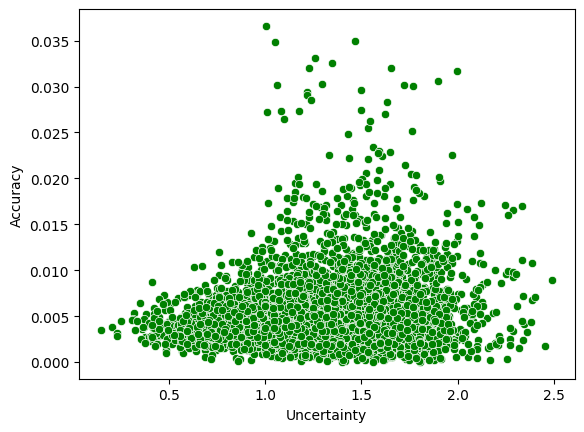

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x=E[:, 0], y=E[:, 1], color="green")



# Add axis labels here:
plt.xlabel("Uncertainty" , color='black')
plt.ylabel("Accuracy"  , color='black')
# plt.xlim(0,4.5)

plt.show()


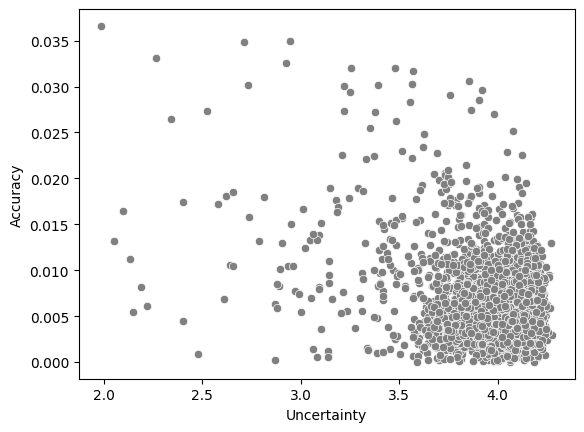

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x=p[:, 0], y=p[:, 1], color="gray")



# Add axis labels here:
plt.xlabel("Uncertainty" , color='black')
plt.ylabel("Accuracy" , color='black')
# plt.xlim(0,4.5)

plt.show()

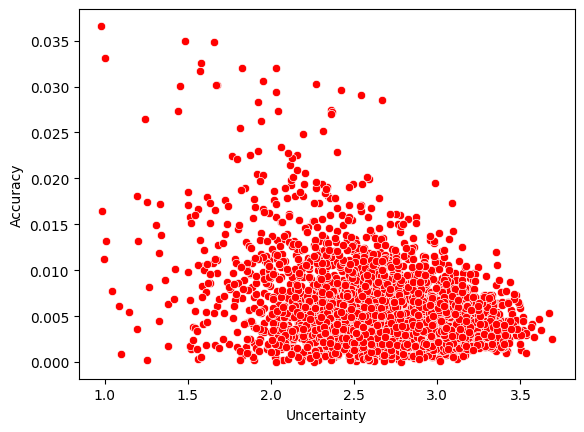

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x=A[:, 0], y=A[:, 1], color="red")



# Add axis labels here:
plt.xlabel("Uncertainty" , color='black')
plt.ylabel("Accuracy" , color='black')
# plt.xlim(0,4.5)

plt.show()